### Backtesting of price prediction model using recurrent neural network (RNN) with long-short term momory cells delta hedged by put options
### Date: 15th December 2018

In [7]:
import numpy as np
import pandas as pd
import math
from datetime import timedelta
from calendar import isleap
#import h5py
import fix_yahoo_finance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as pdr
from time import sleep
from datetime import datetime as dt
import talib as tb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from matplotlib import gridspec
from datetime import datetime, timedelta
from scipy.stats import norm
from dateutil.relativedelta import relativedelta


# Libraries required by FeatureSelector()
import lightgbm as lgb
import gc
from itertools import chain
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import copy
from matplotlib.dates import (DateFormatter, WeekdayLocator, DayLocator, MONDAY)

import tensorflow as tf
import keras
from keras.models import load_model
from keras import backend as K

Using TensorFlow backend.


## Introduction

In Mini Project II, I have created a prediction model using recurrent neural network for the stock AAPL. The model with trained weights are saved and loaded for this Part 1 of this final project. The trained model is able to achieve very low loss rate: 

Train loss: 0.0092
Train mean_squared_error: 0.0003
Train mean_absolute_error: 0.0092
Test loss: 0.0941
Test mean_squared_error: 0.0113
Test mean_absolute_error: 0.0941

The model is trained with data from year 2000 until February 2017. The prediction is done from February 2017 until 13th Dec 2018. I do notice notice that the model accuracy would last only for half a year, after it deteriorates and became increasingly errortic. This shows the importance of having an updated model, re-tuning and re-training the model once a month maybe appropriate. I have tried to re-trained a new model with a new 6 months window. However, even the retrained model requires a whole new tuning to be done. Due to time-constraint , I present the first model in this project and make aware of the shortfall of having an outdated the model. 

Tuning and training a deep neural network model can be time-consuming but the lessons learned in these projects will be valuable to be applied to future real world predictin modelling work. 

#### Note: The supplied pre-trained CNN and RNN models: best_cnn_model_AAPL.h5 & best_lstm_model_AAPL.h5 work only when feature selection algorithm selected 25 features. I notice that certain machine behaves differently and may selects different number of features. In that case, a new training will be needed to use the locally processed features data for prediction.  

### Global Parameters

In [8]:
# Range of date
START = dt(2000, 1, 1)
END = dt(2017, 2, 11)
END_2 = dt(2018, 12, 15)

START_DATE_RANGE = []
END_DATA_RANGE = []
YRMTH_FMT = mdates.DateFormatter('%b %Y')

TRAIN_PORTION = 0.9
ACCOUNT_FUND = 100000
ALLOCATION_RATIO = 0.1
SINGLE_TRADING_FUND = ACCOUNT_FUND * ALLOCATION_RATIO
# Set price impact for slippage
PRICE_IMPACT = 0.1

# risk free rate, 3-month treasury Yield
RFR = 0.0197
# Dividen
DIV = 0.0
ASSET_N = "Apple Inc"
ASSET = "AAPL"

# Change hedge ratio here. For example. 0.75 for 75% hedge. 1 is full delta hedge
PCT = 1.0

## 1 Data Preprocessing

In [9]:
class Data:
    """
    This class prepares data by downloading historical data from pre-saved data.
    """
    
    def __init__(self):
        
        self.load_data()
        self.scale_data()
        self.split_data()
        
        
    def load_data(self):
        
        self.stock_raw_full = pd.read_csv('stock_raw_full.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
        self.original_stock_context_fs_full = pd.read_csv('original_stock_context_fs.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
        self.stock_context_fs_full = pd.read_csv('stock_context_fs_full.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
        self.dow_vix = pdr.DataReader('VXDCLS', 'fred', START, END_2, retry_count=10)
    
        
    def scale_data(self):
        
        train_set_size = int(0.9 * len(self.original_stock_context_fs_full))
        train_set = self.original_stock_context_fs_full[:train_set_size]
        test_set = self.original_stock_context_fs_full[train_set_size:]
        # MinMax scaling
        minmaxed_scaler = MinMaxScaler(feature_range=(0,1))
        self.minmaxed = minmaxed_scaler.fit(train_set)
        train_set_matrix = minmaxed_scaler.transform(train_set)
        test_set_matrix = minmaxed_scaler.transform(test_set)
        train_set_matrix_df = pd.DataFrame(train_set_matrix, index=train_set.index, columns=train_set.columns)
        self.test_set_matrix_df = pd.DataFrame(test_set_matrix, index=test_set.index, columns=test_set.columns)
        self.stock_context_fs_scaled_df = pd.concat([train_set_matrix_df, self.test_set_matrix_df], axis=0)
        
        print ("Train set shape: ", train_set_matrix.shape)
        print ("Test set shape: ", test_set_matrix.shape)
        
    def split_data(self):
        
        df_values = self.stock_context_fs_scaled_df.values
        # split into train and test sets
        n_train = TRAIN_PORTION * df_values.shape[0]
        train = df_values[:int(n_train), :]
        test = df_values[int(n_train):, :]
        # split into input and outputs
        train_X, self.train_y = train[:, :-1], train[:, -1]
        test_X, self.test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        self.train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        self.test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        print("\n")
        print("Train feature data shape:", self.train_X.shape)
        print("Train label data shape:", self.train_y.shape)
        print("Test feature data shape:", self.test_X.shape)
        print("Test label data shape:", self.test_y.shape)

    def get_prediction(self):
        
        model_lstm = keras.models.load_model('./best_lstm_model_AAPL_strange.h5')
        # Get the predicted price
        self.predicted_y_lstm = model_lstm.predict(self.test_X, batch_size=None, verbose=0, steps=None)
        # Get the trained price
        self.trained_y_lstm = model_lstm.predict(self.train_X, batch_size=None, verbose=0, steps=None)
        
    def run_prediction(self):
        
        self.get_prediction()
        # Vertically stack trained and predicted price into a dataframe to form a vector of price produced by CNN
        y_lstm = pd.DataFrame(data=np.vstack((self.trained_y_lstm,self.predicted_y_lstm)), columns=['LSTM'], index = self.stock_context_fs_scaled_df.index )
        # Assemble a dataframe with normalized price of original and CNN trained/predicted price
        lstm_y_df = pd.concat([self.stock_context_fs_scaled_df[['Predict-Y']], y_lstm], axis=1)
        # Assemble the dataframe resembles of the original stock dataframe for inverse transformation. 
        lstm_df = self.stock_context_fs_scaled_df.loc[lstm_y_df.index]
        # Replace the label column with the CNN trained & predicted price column
        lstm_df[['Predict-Y']] = lstm_y_df[['LSTM']]
        # Get it inverse transformed back to normal price
        recovered_data_lstm = self.minmaxed.inverse_transform(lstm_df)
        self.recovered_data_lstm = pd.DataFrame(data=recovered_data_lstm, columns=stock_context_fs_scaled_df.columns, index=lstm_df.index)
       
    def get_train_test_set(self):
        
        return self.train_X, self.train_y, self.test_X, self.test_y

    def get_all_data(self):
        
        return self.stock_context_fs_scaled_df, self.stock_raw_full, self.original_stock_context_fs_full, self.stock_context_fs_full, self.dow_vix
        
        
        

In [10]:
data_processing = Data()
stock_context_fs_scaled_df, stock_raw_full, original_stock_context_fs_full, stock_context_fs_full, dow_vix = data_processing.get_all_data()
train_X, train_y, test_X, test_y = data_processing.get_train_test_set()

Train set shape:  (4256, 26)
Test set shape:  (473, 26)


Train feature data shape: (4256, 1, 25)
Train label data shape: (4256,)
Test feature data shape: (473, 1, 25)
Test label data shape: (473,)


#### The original stock price and its price, volume and technical data

In [11]:
stock_raw_full.tail()  

,OpenT-0,CloseT-0,HighT-0,LowT-0,VolumeT-0,OpenT-1,CloseT-1,HighT-1,LowT-1,VolumeT-1,...,RSI,BBANDS_U,BBANDS_M,BBANDS_L,AD,ATR,HT_DC,High/Open,Low/Open,Close/Open
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-10,165.000000,169.600006,170.089996,163.330002,62026000.0,3.374571,3.277724,3.362573,3.306778,0.353326,...,33.412551,186.553813,174.864004,163.174195,1.834078e+10,6.367566,35.490535,1.030848,0.989879,1.027879
2018-12-11,171.660004,168.630005,171.789993,167.000000,47281700.0,3.209431,3.299317,3.277781,3.209127,0.518319,...,32.812528,178.445509,171.626004,164.806499,1.832568e+10,6.254883,36.134241,1.000757,0.972853,0.982349
2018-12-12,170.399994,169.100006,171.919998,169.020004,35627700.0,3.338976,3.280447,3.310541,3.281235,0.395109,...,33.436273,174.785358,170.108005,165.430651,1.829202e+10,6.043105,35.750055,1.008920,0.991901,0.992371
2018-12-13,170.490005,170.949997,172.570007,169.550003,31898600.0,3.314467,3.289590,3.313047,3.320924,0.297722,...,35.956552,171.130043,169.354004,167.577965,1.828970e+10,5.859312,34.731003,1.012200,0.994486,1.002698
2018-12-14,169.000000,165.479996,169.080002,165.279999,40634300.0,3.316218,3.325579,3.325573,3.331338,0.266560,...,32.087938,172.373306,168.752002,165.130698,1.825334e+10,5.845789,33.336859,1.000473,0.977988,0.979172


#### The original selected feature data comprises of market and stock price, volume and technical data

In [12]:
original_stock_context_fs_full.tail()  

,OpenT-0_M,VolumeT-0_M,ADX_M,ADXR_M,MACD_M,RSI_M,AD_M,ATR_M,HT_DC_M,High/Open_M,...,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-07,2691.260010,4.216690e+09,27.625705,30.599292,-15.247472,39.321326,1.482307e+12,50.935005,18.389741,1.006421,...,41411660.0,40.263123,-8.998128,32.093053,1.828775e+10,33.226658,1.005764,0.970085,0.971180,169.600006
2018-12-10,2630.860107,4.151030e+09,27.915193,30.923952,-19.441600,39.997632,1.485193e+12,51.888221,18.619252,1.006329,...,45910560.0,40.836185,-9.081378,33.412551,1.834078e+10,35.490535,1.030848,0.989879,1.027879,168.630005
2018-12-11,2664.439941,3.905870e+09,27.572068,31.255363,-22.581022,39.900611,1.483567e+12,51.971209,18.510622,1.003719,...,47206400.0,40.996084,-9.120489,32.812528,1.832568e+10,36.134241,1.000757,0.972853,0.982349,169.100006
2018-12-12,2658.229980,3.955890e+09,27.006040,31.416794,-23.643404,42.196250,1.479793e+12,51.734688,18.052704,1.010236,...,46063080.0,41.115068,-9.009702,33.436273,1.829202e+10,35.750055,1.008920,0.991901,0.992371,170.949997
2018-12-13,2658.699951,3.927720e+09,26.677160,31.782807,-24.248595,42.131967,1.479032e+12,50.390776,17.462045,1.004322,...,43823120.0,41.069631,-8.672650,35.956552,1.828970e+10,34.731003,1.012200,0.994486,1.002698,165.479996


#### Scaling done separately. First the scaler is fitted to the train set. The train set is then transformed followed by the tranforming the test set using the train set-fitted scaler.  The model was trained with data fitted to this scaler. The label "Predict-Y"  is tomorrow's close price.

In [13]:
stock_context_fs_scaled_df.tail()  

,OpenT-0_M,VolumeT-0_M,ADX_M,ADXR_M,MACD_M,RSI_M,AD_M,ATR_M,HT_DC_M,High/Open_M,...,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-07,1.242162,0.347799,0.426955,0.506093,0.555125,0.388116,1.154938,0.772838,0.194199,0.059512,...,0.032248,0.540755,-0.490098,0.201810,0.957093,0.604348,0.034544,0.860876,0.362983,1.277141
2018-12-10,1.204872,0.341883,0.433297,0.513635,0.517544,0.398337,1.157175,0.790088,0.200946,0.058659,...,0.038697,0.550303,-0.499034,0.219538,0.959306,0.673151,0.184875,0.952930,0.588582,1.269796
2018-12-11,1.225604,0.319797,0.425780,0.521333,0.489414,0.396871,1.155915,0.791590,0.197753,0.034474,...,0.040555,0.552968,-0.503232,0.211477,0.958676,0.692714,0.004538,0.873751,0.407423,1.273355
2018-12-12,1.221770,0.324303,0.413379,0.525083,0.479895,0.431563,1.152991,0.787310,0.184292,0.094875,...,0.038916,0.554950,-0.491340,0.219857,0.957272,0.681038,0.053459,0.962337,0.447300,1.287363
2018-12-13,1.222060,0.321766,0.406174,0.533586,0.474472,0.430592,1.152401,0.762989,0.166929,0.040056,...,0.035705,0.554193,-0.455160,0.253718,0.957175,0.650067,0.073116,0.974359,0.488390,1.245943


We can see that the last 1 year values for the label data "Predict-Y" for both dataset:  stock_context_fs_scaled_df and stock_context_fs_full are very different. 
stock_context_fs_scaled_df's label data ends with 1.2+ , stock_context_fs_full ends with 0.71.
The MiniMax scaler is set to range between 0 to 1. The former dataset completely unexpect the large price appreciation in 2018 and output values exceed the scaler range. Whereas the latter take that into account and fit that expectation into the model. 


#### Full dataset scaled at once

In [14]:
stock_context_fs_full.tail()  

,OpenT-0_M,VolumeT-0_M,ADX_M,ADXR_M,MACD_M,RSI_M,AD_M,ATR_M,HT_DC_M,High/Open_M,...,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-07,0.891250,0.347799,0.415455,0.506093,0.496170,0.351580,0.995692,0.772838,0.194199,0.059512,...,0.036956,0.524215,0.113314,0.201810,0.957093,0.604348,0.034544,0.860876,0.362983,0.729723
2018-12-10,0.864495,0.341883,0.421627,0.513635,0.462581,0.360839,0.997620,0.790088,0.200946,0.058659,...,0.043374,0.533471,0.108722,0.219538,0.959306,0.673151,0.184875,0.952930,0.588582,0.725526
2018-12-11,0.879370,0.319797,0.414312,0.521333,0.437438,0.359510,0.996534,0.791590,0.197753,0.034474,...,0.045223,0.536054,0.106565,0.211477,0.958676,0.692714,0.004538,0.873751,0.407423,0.727559
2018-12-12,0.876619,0.324303,0.402246,0.525083,0.428929,0.390937,0.994013,0.787310,0.184292,0.094875,...,0.043592,0.537976,0.112675,0.219857,0.957272,0.681038,0.053459,0.962337,0.447300,0.735563
2018-12-13,0.876827,0.321766,0.395235,0.533586,0.424083,0.390057,0.993504,0.762989,0.166929,0.040056,...,0.040396,0.537242,0.131266,0.253718,0.957175,0.650067,0.073116,0.974359,0.488390,0.711897


Since model training and tuning are already done, the train set isn't much useful from here on. It is merely to get the fitted scaler to transform the test set for backtesting since that's the scaler the model was using during training. 

## 2 Prediction with pre-trained RNN model

In [15]:
def plot_prediction(original, trained, train_len, nn):

    """
    Function to plot all portfolio cumulative returns
    """
    # Set a palette so that all 14 lines can be better differentiated
    color_palette = ['#e6194b', '#3cb44b', '#4363d8']
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(original.index, original, '-', label="Original price", linewidth=2, color=color_palette[0])
    ax.plot(trained.iloc[:train_len].index, trained.iloc[:train_len], '-', label="Trained price", linewidth=2,
            color=color_palette[1], alpha=0.8)
    ax.plot(trained.iloc[train_len:].index, trained.iloc[train_len:], '-', label="Predicted price", linewidth=2,
            color=color_palette[2])
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock price')
    plt.title('Original, trained & predicted stock price trained on {} model for {}'.format(nn, ASSET))
    plt.subplots_adjust(hspace=0.5)

    # Display and save the graph
    plt.savefig('prediction_{}_{}.png'.format(nn, ASSET))
    # Inform user graph is saved and the program is ending.
    print(
        "Plot saved as prediction_{}.png. When done viewing, please close this plot for next plot. Thank You!".format(
            nn))
    plt.show()

### Recurrent Neural network with LSTM model loading and prediction

#### Pre-trained model can only loaded if the Keras version installed in your machine is Version 2.2.4

In [16]:
import keras
print(keras.__version__)

2.2.4


#### If Keras version is 2.2.4, please execute the following

In [17]:
data_processing.run_prediction()
recovered_data_lstm = data_processing.recovered_data_lstm
train_len = len(data_processing.trained_y_lstm)
test_set = data_processing.test_set_matrix_df

#### The pre-trained RNN model returns the following prediction:

In [18]:
recovered_data_lstm.tail()  

,OpenT-0_M,VolumeT-0_M,ADX_M,ADXR_M,MACD_M,RSI_M,AD_M,ATR_M,HT_DC_M,High/Open_M,...,MA5,ADX,MACD,RSI,AD,HT_DC,High/Open,Low/Open,Close/Open,Predict-Y
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-07,2691.260010,4.216690e+09,27.625705,30.599292,-15.247472,39.321326,1.482307e+12,50.935005,18.389741,1.006421,...,41411660.0,40.263123,-8.998128,32.093053,1.828775e+10,33.226658,1.005764,0.970085,0.971180,175.326274
2018-12-10,2630.860107,4.151030e+09,27.915193,30.923952,-19.441600,39.997632,1.485193e+12,51.888221,18.619252,1.006329,...,45910560.0,40.836185,-9.081378,33.412551,1.834078e+10,35.490535,1.030848,0.989879,1.027879,172.192134
2018-12-11,2664.439941,3.905870e+09,27.572068,31.255363,-22.581022,39.900611,1.483567e+12,51.971209,18.510622,1.003719,...,47206400.0,40.996084,-9.120489,32.812528,1.832568e+10,36.134241,1.000757,0.972853,0.982349,174.183717
2018-12-12,2658.229980,3.955890e+09,27.006040,31.416794,-23.643404,42.196250,1.479793e+12,51.734688,18.052704,1.010236,...,46063080.0,41.115068,-9.009702,33.436273,1.829202e+10,35.750055,1.008920,0.991901,0.992371,173.907488
2018-12-13,2658.699951,3.927720e+09,26.677160,31.782807,-24.248595,42.131967,1.479032e+12,50.390776,17.462045,1.004322,...,43823120.0,41.069631,-8.672650,35.956552,1.828970e+10,34.731003,1.012200,0.994486,1.002698,173.861455


#### A note about Volatility index used to calculate AAPL's options premium. Suppose to be Apple's VIX index, VXAPL. However historical VXAPL is not easily available, replacing it with Dow volatility index for demonstration purpose

In [ ]:
yf.pdr_override()
VXAPL = pdr.get_data_yahoo('^VXAPL', START, END)

In [130]:
VXAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-14,33.810001,44.529999,32.830002,35.470001,35.470001,0


#### Prediction generated by model which is trained by training data. The test data is fitted to training data's scaler.
From the prediction plot, we can see that both the model and scaler did not expect the sharp stock movement in year 2018. In much of 2017 the model is doing a fairly good job in predicting the stock evolutionary trajectory, as time goes it loses its validity. The behavior in 2018 is very much out of what the model learned. In real world trading, we need to retrain and retune the model as more data is made available. 

Plot saved as prediction_LSTM.png. When done viewing, please close this plot for next plot. Thank You!


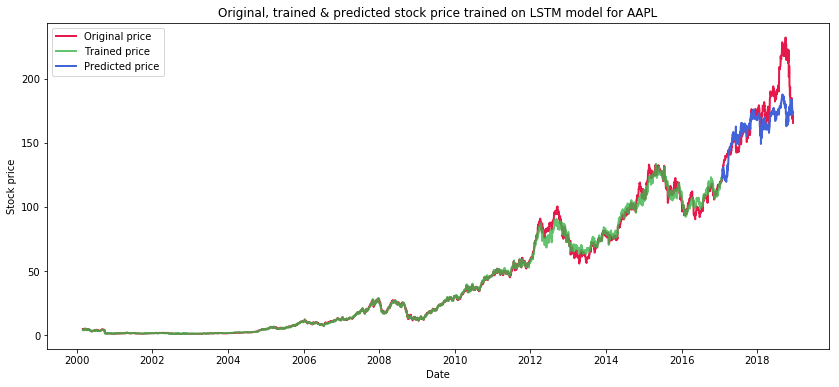

In [19]:
plot_prediction(
    original_stock_context_fs_full[['Predict-Y']].loc[recovered_data_lstm.index], 
    recovered_data_lstm[['Predict-Y']] , train_len, "LSTM")

#### Prediction by the same model but data is scaled all at once: Train and test fit to one scaler. 
In real life we don't get to this perfect situation since we do not know the future data when we scale training data to fit into model. If we know the full data, prediction is not needed. Also if the full dataset is scaled at once, we are kind of feeding future unknown information into current model. The current model shouldn't know future price range, particularly if it is beyond current range. Model trained with this scaler is not realistic and may not generalize well. 

Plot saved as prediction_LSTM.png. When done viewing, please close this plot for next plot. Thank You!


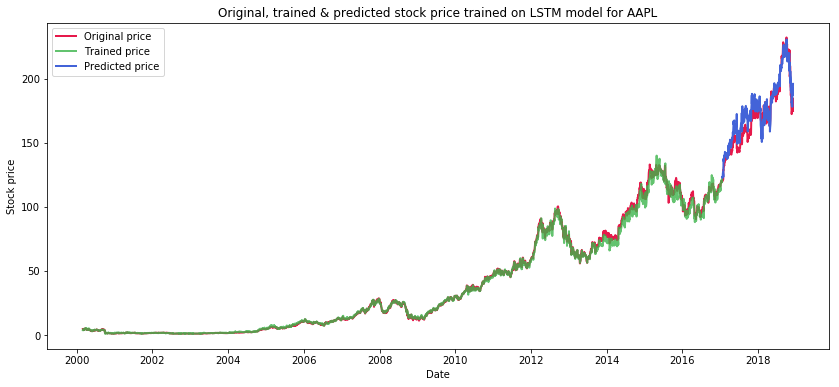

In [19]:
plot_prediction(
    stock_data.original[['Predict-Y']].loc[recovered_data_lstm.index], 
    recovered_data_lstm[['Predict-Y']] , trained_len, "LSTM")

#### Deterioration of outdated model

The deviation from target label show the derioration of a trained neural network model. From the prediction deviation below, we can see that model trained with train set data and both train and test data fitted with train set scaler performance starts to deteriote few months down the road. 

In [20]:
prediction_deviation = recovered_data_lstm.loc[test_set.index][['Predict-Y']] - original_stock_context_fs_full.loc[test_set.index][['Predict-Y']]

Plot saved as prediction_deviation_AAPL.png. When done viewing, please close this plot for next plot. Thank You!


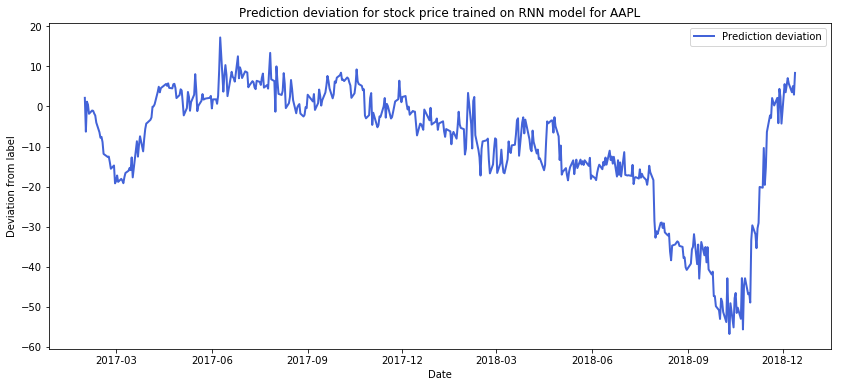

In [21]:
def plot_deviation(prediction_deviation):
    color_palette = ['#4363d8']
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(prediction_deviation.index, prediction_deviation, '-', label="Prediction deviation", linewidth=2, color=color_palette[0])
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Deviation from label')
    plt.title('Prediction deviation for stock price trained on RNN model for {}'.format(ASSET))
    plt.subplots_adjust(hspace=0.5)

    # Display and save the graph
    plt.savefig('prediction_deviation_{}.png'.format(ASSET))
    # Inform user graph is saved and the program is ending.
    print(
        "Plot saved as prediction_deviation_{}.png. When done viewing, please close this plot for next plot. Thank You!".format(
            ASSET))
    plt.show()
plot_deviation(prediction_deviation)

## 3 Backtesting 

Options price, slippage and commission simulations are including in backtesting

### Note: Please proceed to lead all classes at the bottom of this notebook before proceeding further

In [22]:
stock_trading = Trading(recovered_data_lstm, stock_raw_full, test_set, dow_vix)

In [23]:
portfolio_returns_model, kpi_model, stocks_values_model, signals_model = stock_trading.execute_trading()
portfolio_returns_buyhold, kpi_buyhold, stocks_values_buyhold = stock_trading.buyandhold_trade()

/home/jiew/anaconda3/envs/aind/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
 kpi_model

,Win %,Win to Loss Ratio,Max Consecutive Losers,Max dd,CAGR,Lake ratio,Gain to Pain
AAPL,12.262156,3.866667,3,-0.02,0.0536325,0.00415449,0.462945


In [25]:
kpi_buyhold

,Win %,Win to Loss Ratio,Max Consecutive Losers,Max dd,CAGR,Lake ratio,Gain to Pain
AAPL,NaN,NaN,NaN,-0.05,0.021501,0.00589281,0.128542


In [26]:
stocks_values_model

,Stock Price,Stock Quantity,Options Quantity,Profit & Loss,Trade Returns,Portfolio Value,Options Value,Account Value,Total Value
Date,,,,,,,,,
2017-01-30,121.63,164.433,1.64433,0,NaN,20000,213.478,79785.7,99999.2
2017-01-31,121.35,164.433,1.64433,0,NaN,19954,156.535,79785.7,99896.2
2017-02-01,128.75,164.433,1.64433,0,NaN,21170.8,210.244,79785.7,101167
2017-02-02,128.53,164.433,1.64433,0,NaN,21134.6,232.212,79785.7,101152
2017-02-03,129.08,164.433,1.64433,0,NaN,21225,174.026,79785.7,101185
2017-02-06,130.29,164.433,1.64433,0,NaN,21424,160.154,79785.7,101370
2017-02-07,131.53,164.433,1.64433,0,NaN,21627.9,224.879,79785.7,101638
2017-02-08,132.04,164.433,1.64433,0,NaN,21711.7,188.956,79785.7,101686
2017-02-09,132.42,164.433,1.64433,0,NaN,21774.2,150.817,79785.7,101711


In [27]:
 portfolio_returns_model

,Total Values,ProfitLoss,Returns,CumReturns
Date,,,,
2017-01-30,99999.2,0,NaN,1.000000
2017-01-31,99896.2,-102.984,-0.00102985,0.998970
2017-02-01,101167,1270.51,0.0127184,1.011675
2017-02-02,101152,-14.2082,-0.000140444,1.011533
2017-02-03,101185,32.2534,0.000318859,1.011856
2017-02-06,101370,185.09,0.00182923,1.013707
2017-02-07,101638,268.623,0.00264993,1.016393
2017-02-08,101686,47.9368,0.000471641,1.016872
2017-02-09,101711,24.3464,0.000239426,1.017116


Plot saved as AAPL_trade_signal.png. Please close this plot for next plot


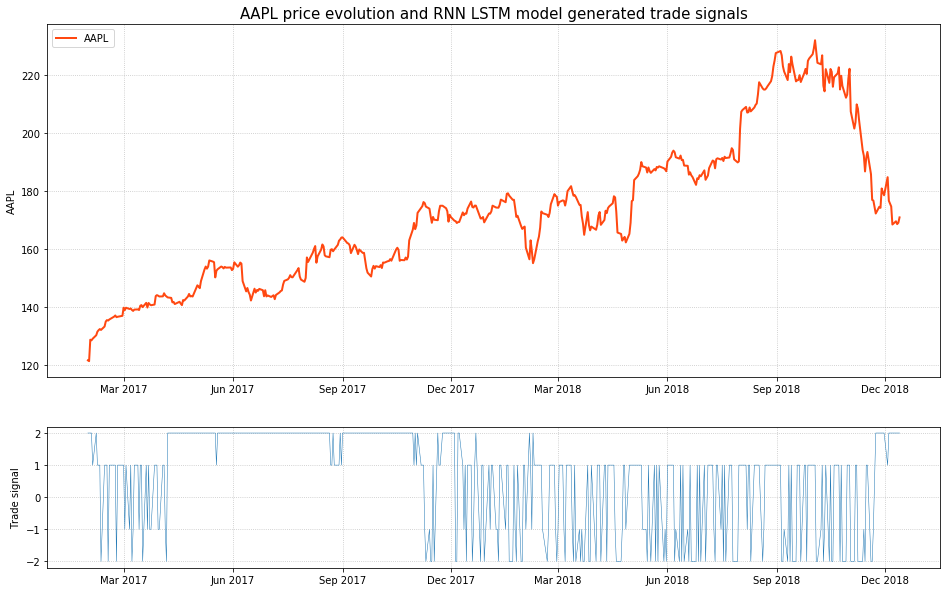

Plot saved as AAPL_cumreturns.png. When done viewing, please close this plot. Thank You!


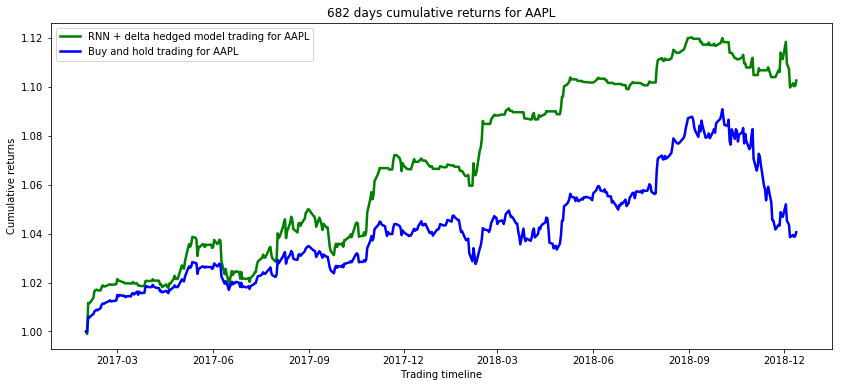

In [28]:
trading_plot =  UserInterfaceDisplay(ASSET)
trading_plot.plot_signal(stock_raw_full.loc[signals_model.index][['CloseT-0']], signals_model)
trading_plot.plot_returns(portfolio_returns_model[['CumReturns']], portfolio_returns_buyhold[['CumReturns']])

## Conclusion

In Mini Project 2, a number of model architectures, optimizers, hyperparameter adjustment and normalization techniques were tried. This project use the most finely tuned model from Mini project 2 for price prediction backtesting. 

According to backtesting, the model generalizes fairly well to unseen data. Though, it also shows that however however good a model is , it will not last long and will need to be updated regularly. Tuning updated model may not be easy as the few hyperparameter adjustment in previous may not works as well. 

Delta hedging the model is a safe bet and it works well if the right delta hedge is constructed. The backtesting is a little unrealistic given fractional delta hedge is allow to match the stock trades. In reality, we can only get a near and not so ideal hedge. 

I also see the shortfall of this model, it is sensitive to normalization method and the period of data normalization is done. Normalizing the entire dataset (train and test) at once to get a perfect model is unrealistic. It seriously discount the model's robustness. 

Lastly, I also learned that daily data length is insufficient for neural network model. If data is not enough, we can't build a deep neural network model as there maybe little to learn and is prone to overfitting. However, getting data too far back in history may make produce a less relevant model. The way I can think of is to use intraday data or fabricate data from existing data, especially behaviors that is rare in occurence. 

For improvements, I suggest: 

1. Having updated model at every interval, for example: every month. 
2. More context and fundamental data. 
3. Predict returns instead of price. 
4. Try reinforcement learning algorithm

## References

1. Display Deep Learning Model Training History in Keras, https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
2.  Multivariate Time Series Forecasting with LSTMs in Keras, https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
3. Deep Learning with Python, Francois Chollet, 2017
4. A Feature Selection Tool for Machine Learning in Python, https://towardsdatascience.com/a-feature-selection-tool-for-machine-learning-in-python-b64dd23710f0
5. Keras documentation, https://keras.io/
6. Dropout Regularization in Deep Learning Models With Keras, https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/


In [3]:
class Trading:

    def __init__(self, recovered_data_lstm, stock_raw_full, test_set, dow_vix):
        self.daily_c = stock_raw_full.loc[test_set.index]['CloseT-0']
        self.daily_v = stock_raw_full.loc[test_set.index]['VolumeT-0']
        self.test_set =  test_set
        self.dow_vix = dow_vix
        
        self.generate_signals(recovered_data_lstm)
        
    
    def slippage_price(self, order, price, stock_quantity, day_volume):
        """
        This function performs slippage price calculation using Zipline's volume share model
        https://www.zipline.io/_modules/zipline/finance/slippage.html
        """

        volumeShare = stock_quantity / float(day_volume)
        impactPct = volumeShare ** 2 * PRICE_IMPACT

        if order > 0:
            slipped_price = price * (1 + impactPct)
        else:
            slipped_price = price * (1 - impactPct)

        # print order, " price: ", price, "slipped price: ", slipped_price
        return slipped_price
    
    def commission(self, num_share, share_value):
        """
        This function computes commission fee of every trade
        https://www.interactivebrokers.com/en/index.php?f=1590&p=stocks1
        """

        comm_fee = 0.005 * num_share
        max_comm_fee = 0.005 * share_value

        if num_share < 1.0:
            comm_fee = 1.0
        elif comm_fee > max_comm_fee:
            comm_fee = max_comm_fee

        return comm_fee
    
    def calc_option_premium(self, day):
        
        # Just in case DOW VIX is not available on the stock trading day
        while day not in self.dow_vix.index:
            day = day - timedelta(days=1)
        # Put option
        right = 'P'
        # Proxy volatility with Cboe DJIA Volatility Index, VXD
        
        vol = self.dow_vix.loc[day].VXDCLS / 100
        # Current underlying price
        s = self.daily_c.loc[day]
        # Strike price is 3 strikes out-of-money, +3.5 is approximately 3-4 strikes away
        k = round(s, 0) + 0
        # Current date when option is transacted
        eval_date = day.strftime('%Y%m%d')
        # Expiry date
        exp_date = (day + relativedelta(weeks=+2)).strftime('%Y%m%d')
        opt_contract = Option(s=s, k=k, eval_date=eval_date, exp_date=exp_date, rf=RFR, vol=vol, right=right,
                              div=DIV)
        premium, delta, theta, gamma = opt_contract.get_all()
        return premium
    
    def generate_signals(self, recovered_data_lstm):
        
        predicted_tomorrow_close = recovered_data_lstm.loc[self.test_set.index]['Predict-Y']
        today_close = self.daily_c.loc[predicted_tomorrow_close.index]
        predicted_next_day_returns = predicted_tomorrow_close / predicted_tomorrow_close.shift(1) - 1
        next_day_returns = today_close / today_close.shift(1) - 1
        signals = pd.DataFrame(index=predicted_tomorrow_close.index, columns=["Signal"])
        for d in predicted_tomorrow_close.index:
            if predicted_tomorrow_close.loc[d] > today_close.loc[d] and next_day_returns.loc[d] > 0 and predicted_next_day_returns.loc[d] > 0:
                signals.loc[d]["Signal"] = 2
            elif predicted_tomorrow_close.loc[d] < today_close.loc[d] and next_day_returns.loc[d] < 0 and predicted_next_day_returns.loc[d] < 0:
                signals.loc[d]["Signal"] = -2
            elif predicted_tomorrow_close.loc[d] > today_close.loc[d]:
                signals.loc[d]["Signal"] = 2
            elif next_day_returns.loc[d] > 0:
                signals.loc[d]["Signal"] = 1
            elif next_day_returns.loc[d] < 0:
                signals.loc[d]["Signal"] = -1
            elif predicted_next_day_returns.loc[d] > 0:
                signals.loc[d]["Signal"] = 2
            elif predicted_next_day_returns.loc[d] < 0:
                signals.loc[d]["Signal"] = -1        
            else: 
                signals.loc[d]["Signal"] = 0
        self.signals = signals
        
    def execute_trading(self):
        """
        This function performs long only trades.
        """
        # Call up trading signla caculation
        account_value = ACCOUNT_FUND
        stocks_values = pd.DataFrame(index=self.daily_c.index,
                        columns=["Stock Price", "Stock Quantity","Options Quantity", "Profit & Loss", "Trade Returns", 
                                 "Portfolio Value", "Options Value", "Account Value", "Total Value"])
        stock_quantity = 0
        account_profit_holder = 0
        account_equity_holder = 0
        contract_to_hedge = 0
        premium_value = 0

        # Slide through the timeline
        for d in self.daily_c.index:
            # if this is the first hour and signal is buy
            if (d == self.daily_c.index[0]) and (stock_quantity == 0) and (self.signals.loc[d]['Signal'] >= 1):
                if self.signals.loc[d]['Signal'] == 1:
                    stock_quantity = SINGLE_TRADING_FUND / self.daily_c.loc[d]
                    portfolio_value = SINGLE_TRADING_FUND
                elif self.signals.loc[d]['Signal'] == 2:
                    stock_quantity = SINGLE_TRADING_FUND * 2.0/ self.daily_c.loc[d]
                    portfolio_value = SINGLE_TRADING_FUND * 2.0
                slipped_price = self.slippage_price(self.signals.loc[d]['Signal'], self.daily_c.loc[d], stock_quantity,
                                                    self.daily_v.loc[d])
                
                # 1 contract is equivalent to 100 delta which covers 100 stocks, calculate the contract to delta hedge
                # assuming fractional contract is avialable if stock_quantity is less than is not an integer number
                
                options_premium = self.calc_option_premium(d)
                contract_to_hedge = stock_quantity/100 *PCT
                premium_value = contract_to_hedge * options_premium * 100
                
                realized_pnl = 0.0
                realized_ret = float('nan')
                buy_price = slipped_price
                commission_cost = self.commission(stock_quantity, portfolio_value)
                account_value = account_value - portfolio_value - commission_cost - premium_value

            # if this the first hour and no trading signal
            elif d == self.daily_c.index[0] and self.signals.loc[d]['Signal'] < 1:
                stock_quantity = 0
                portfolio_value = 1
                realized_pnl = 0.0
                realized_ret = float('nan')
                buy_position = 0
                premium_value = 0

            # if there's existing position and trading signal is sell
            elif stock_quantity > 0 and self.signals.loc[d]['Signal'] < 0:
                slipped_price = self.slippage_price(self.signals.loc[d]['Signal'], self.daily_c.loc[d], stock_quantity,
                                                        self.daily_v.loc[d])
                
                # Close the hedge also
                options_premium = self.calc_option_premium(d)
                premium_value = contract_to_hedge * options_premium * 100
                
                realized_pnl = stock_quantity * (slipped_price - buy_price) + premium_value
                
                realized_ret = realized_pnl / (stock_quantity * buy_price)
                commission_cost = self.commission(stock_quantity, (stock_quantity * slipped_price))
                account_value = account_value + (stock_quantity * slipped_price) - commission_cost + premium_value
                stock_quantity = 0
                portfolio_value = 0.0
                premium_value = 0
                contract_to_hedge = 0
                
                
            # With position, hold and no trading signal, just update portfolio value with latest price
            elif stock_quantity > 0 and self.signals.loc[d]['Signal'] >= 0:
                portfolio_value = stock_quantity * self.daily_c.loc[d]
                realized_pnl = 0.0
                realized_ret = float('nan')
                
                options_premium = self.calc_option_premium(d)
                premium_value = contract_to_hedge * options_premium * 100

            # With no position, trading signal is buy
            elif stock_quantity == 0 and self.signals.loc[d]['Signal'] >= 1:
                if self.signals.loc[d]['Signal'] == 1:
                    stock_quantity = SINGLE_TRADING_FUND / self.daily_c.loc[d]
                    portfolio_value = SINGLE_TRADING_FUND
                elif self.signals.loc[d]['Signal'] == 2:
                    stock_quantity = SINGLE_TRADING_FUND * 2/ self.daily_c.loc[d]
                    portfolio_value = SINGLE_TRADING_FUND * 2
                slipped_price = self.slippage_price(self.signals.loc[d]['Signal'], self.daily_c.loc[d], stock_quantity,
                                                    self.daily_v.loc[d])
                buy_price = slipped_price
                realized_pnl = 0.0
                realized_ret = float('nan')
                commission_cost = self.commission(stock_quantity, slipped_price * stock_quantity)
                options_premium = self.calc_option_premium(d)
                contract_to_hedge = stock_quantity/100 *PCT
                premium_value = contract_to_hedge * options_premium * 100
                
                account_value = account_value - (slipped_price * stock_quantity) - commission_cost - premium_value


            # With no position, trading signal is not buy, do nothing
            elif stock_quantity == 0 and self.signals.loc[d]['Signal'] < 1:
                realized_pnl = 0.0
                realized_ret = float('nan')
                premium_value = 0

            # Record it in the stock position value book
            stocks_values["Profit & Loss"].loc[d] = realized_pnl
            stocks_values["Trade Returns"].loc[d] = realized_ret
            stocks_values["Stock Quantity"].loc[d] = stock_quantity
            stocks_values["Options Quantity"].loc[d] = contract_to_hedge
            stocks_values["Portfolio Value"].loc[d] = portfolio_value
            stocks_values["Options Value"].loc[d] = premium_value    
            stocks_values["Stock Price"].loc[d] = self.daily_c.loc[d]
            stocks_values["Account Value"].loc[d] = account_value
            account_equity = stocks_values["Portfolio Value"].loc[d] + stocks_values["Account Value"].loc[d]
            account_profit = stocks_values["Profit & Loss"].sum()
        
        stocks_values["Total Value"] = stocks_values["Portfolio Value"] + stocks_values["Account Value"] + stocks_values["Options Value"]
        # Calculate trading book
        portfolio_returns = MathCalc.construct_book(stocks_values["Total Value"])
        # Calculate trade KPI
        kpi = MathCalc.calc_kpi(portfolio_returns, stocks_values, ASSET)
        return portfolio_returns, kpi, stocks_values, self.signals

    def buyandhold_trade(self):
        """
        This function performs a long only trade on 10 randomly chosen Dow stocks on the first day of trading, hold the
        stocks until the last trading day in the window.
        """
        # Calculate equally weighted fund allocation for each stock

        stock_quantity =  SINGLE_TRADING_FUND / self.daily_c.iloc[0]
        stocks_values = self.daily_c.mul(stock_quantity) + (ACCOUNT_FUND - SINGLE_TRADING_FUND)
        portfolio_returns = MathCalc.construct_book(stocks_values)
        kpi = MathCalc.calc_kpi(portfolio_returns, stocks_values, ASSET)

        return portfolio_returns, kpi, stocks_values

In [4]:
class MathCalc:
    """
    This class performs all the mathematical calculations
    """

    def __init__(self, daily_data):

        # Make sure hourly data index is datetime format, not simply string.
        daily_data.index = pd.to_datetime(daily_data.index)
        # Only needs the Close data
        self.daily = daily_data

    @staticmethod
    def diff_year(start_date, end_date):
        """
        This function computes the fractional year for CAGR calculation
        """
        diffyears = end_date.year - start_date.year
        difference = end_date - start_date.replace(end_date.year)
        days_in_year = isleap(end_date.year) and 366 or 365
        difference_in_years = diffyears + (difference.days + difference.seconds / 86400.0) / days_in_year
        return difference_in_years

    @staticmethod
    def cagr(portfolio_value):
        """
        This function computes CAGR
        """
        st = portfolio_value.index[0]
        en = portfolio_value.index[-1]
        num_year = MathCalc.diff_year(st, en)
        return (portfolio_value[-1] / portfolio_value[0]) ** (1.0 / float(num_year)) - 1

    @staticmethod
    def calc_return(period):
        """
        This function compute the return of a series
        """
        period_return = period / period.shift(1) - 1
        return period_return[1:len(period_return)]

    @staticmethod
    def max_drawdown(r):
        """
        This function calculates maximum drawdown occurs in a series of cummulative returns
        """
        dd = r.div(r.cummax()).sub(1)
        maxdd = dd.min()
        return round(maxdd, 2)

    @staticmethod
    def calc_gain_to_pain(returns):
        """
        This function computes the gain to pain ratio given a series of profits and losses

        """
        profit_loss = np.array(returns)
        sum_returns = returns.sum()
        sum_neg_months = abs(returns[returns < 0].sum())
        gain_to_pain = sum_returns / sum_neg_months

        # print "Gain to Pain ratio: ", gain_to_pain
        return gain_to_pain

    @staticmethod
    def calc_lake_ratio(series):

        """
        This function computes lake ratio

        """
        water = 0
        earth = 0
        series = series.dropna()
        water_level = []
        for i, s in enumerate(series):
            if i == 0:
                peak = s
            else:
                peak = np.max(series[0:i])
            water_level.append(peak)
            if s < peak:
                water = water + peak - s
            earth = earth + s
        return water / earth

    @staticmethod
    def construct_book(stocks_values):
        """
        This function construct the trading book for stock trading
        """
        portfolio = pd.DataFrame(index=stocks_values.index, columns=["Total Values", "ProfitLoss", "Returns", "CumReturns"])
        portfolio["Total Values"] = stocks_values
        portfolio["ProfitLoss"] = portfolio["Total Values"] - portfolio["Total Values"].shift(1).fillna(portfolio["Total Values"][0])
        portfolio["Returns"] = portfolio["Total Values"] / portfolio["Total Values"].shift(1) - 1
        portfolio["CumReturns"] = portfolio["Returns"].add(1).cumprod().fillna(1)

        return portfolio

    @staticmethod
    def winpct(realized_pnl):
        return float(len(realized_pnl[realized_pnl > 0])) / float(len(realized_pnl)) * 100

    @staticmethod
    def winloss(realized_pnl):
        """
        This function calculates win to loss ratio
        """
        return float(len(realized_pnl[realized_pnl > 0])) / float(len(realized_pnl[realized_pnl < 0]))

    @staticmethod
    def meanreturn_trade(realized_pnl, current_value):
        """
        This function calculates the mean of all trade returns
        """

        previous_value = current_value - realized_pnl
        trade_return = realized_pnl / previous_value

        return trade_return.mean()

    @staticmethod
    def longestconsecutive_loss(arr):
        """
        This function computes the longest losing streak
        """

        # remove all non trading activities
        arr = list(filter(lambda a: a != 0, arr))

        n = len(arr)
        # Initialize result
        res = 0

        # Traverse array
        for i in range(n):

            # Count of current
            # non-negative integers
            curr_count = 0
            while (i < n and arr[i] < 0):
                curr_count += 1
                i += 1

            # Update result if required.
            res = max(res, curr_count)

        return res

    @staticmethod
    def calc_kpi(portfolio, stock_values, symbol):
        """
        This function calculates individual portfolio KPI related its risk-return profile
        """
        KPI = ['Win %', 'Win to Loss Ratio', 'Max Consecutive Losers', 'Max dd', 'CAGR',
               'Lake ratio', 'Gain to Pain']

        kpi = pd.DataFrame(index=[symbol], columns=KPI)
        try:
            kpi['Win %'] = MathCalc.winpct(stock_values["Profit & Loss"])
            kpi['Win to Loss Ratio'] = MathCalc.winloss(stock_values["Profit & Loss"])
            kpi['Max Consecutive Losers'] = MathCalc.longestconsecutive_loss(stock_values["Profit & Loss"])
            kpi['CAGR'].iloc[0] = MathCalc.cagr(portfolio["Total Values"])
            kpi['Max dd'].iloc[0] = MathCalc.max_drawdown(portfolio["CumReturns"])
            kpi['Lake ratio'].iloc[0] = MathCalc.calc_lake_ratio(portfolio['CumReturns'])
            kpi['Gain to Pain'].iloc[0] = MathCalc.calc_gain_to_pain(portfolio['Returns'])
        except: 
            kpi['Win %'] = float('nan')
            kpi['Win to Loss Ratio'] = float('nan')
            kpi['Max Consecutive Losers'] = float('nan')
            kpi['CAGR'].iloc[0] = MathCalc.cagr(stock_values)
            kpi['Max dd'].iloc[0] = MathCalc.max_drawdown(portfolio["CumReturns"])
            kpi['Lake ratio'].iloc[0] = MathCalc.calc_lake_ratio(portfolio['CumReturns'])
            kpi['Gain to Pain'].iloc[0] = MathCalc.calc_gain_to_pain(portfolio['Returns'])
            
        return kpi

In [5]:
class UserInterfaceDisplay:
    """
    The class to display plot(s) to users
    """

    def __init__(self, symbol):
        self.symbol = symbol
     
    def plot_signal(self, series, signal):
        """
        This function plots the time series together with respective trading signals and indicators

        """

        month = mdates.AutoDateLocator()
        fig = plt.figure(figsize=(16, 10))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1])
        ax1 = plt.subplot(gs[0])
        ax1.set_title("{} price evolution and RNN LSTM model generated trade signals".format(self.symbol),
                      fontsize=15)
        ax1.plot(series.index, series, label='{}'.format(self.symbol), c='#ff4811', linewidth=2)
        ax1.set_ylabel(self.symbol)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.8, ls=':')
        ax1.xaxis.set_major_locator(month)
        ax1.xaxis.set_major_formatter(YRMTH_FMT)
        ax1.xaxis_date()
        ax1.autoscale_view()
        plt.setp(plt.gca().get_xticklabels(), rotation=0)

        ax2 = plt.subplot(gs[1])
        ax2.plot(signal.index, signal, linewidth=0.5)
        ax2.set_ylabel('Trade signal')
        ax2.xaxis.set_major_locator(month)
        ax2.xaxis.set_major_formatter(YRMTH_FMT)
        ax2.grid(True, alpha=0.8, ls=':')
        plt.setp(plt.gca().get_xticklabels(), rotation=0)

        print("Plot saved as {}_trade_signal.png. Please close this plot for next plot".format(self.symbol))
        plt.savefig('{}_trade_signal.png'.format(self.symbol))
        plt.show()

    def plot_returns(self, cum_returns_model, cum_returns_buyhold):
        """
        Function to plot the trade cumulative returns
        """
        trading_days = cum_returns_model.index[-1] -  cum_returns_model.index[0]
        
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(cum_returns_model.index, cum_returns_model, '-', label="RNN + delta hedged model trading for {}".format(self.symbol), linewidth=2.5, color='g')
        ax.plot(cum_returns_buyhold.index, cum_returns_buyhold, '-', label="Buy and hold trading for {}".format(self.symbol), linewidth=2.5, color='b')
        plt.legend()
        plt.xlabel('Trading timeline')
        plt.ylabel('Cumulative returns')
        plt.title('{} days cumulative returns for {}'.format(trading_days.days, self.symbol))
        # Display and save the graph
        plt.savefig('{}_cumreturns.png'.format(self.symbol))
        # Inform user graph is saved and the program is ending.
        print(
            "Plot saved as {}_cumreturns.png. When done viewing, please close this plot. Thank You!".format(
                self.symbol))
        plt.show()

In [6]:
class Option:
    """
    This class computes option greeks & premiums using Black-scholes calculations
    """

    def __init__(self, right, s, k, eval_date, exp_date, price=None, rf=0.01, vol=0.3,
                 div=0):
        self.k = float(k)
        self.s = float(s)
        self.rf = float(rf)
        self.vol = float(vol)
        self.eval_date = eval_date
        self.exp_date = exp_date
        self.t = self.calculate_t()
        if self.t == 0: self.t = 0.000001  ## Case valuation in expiration date
        self.price = price
        self.right = right  ## 'C' or 'P'
        self.div = div

    def calculate_t(self):
        if isinstance(self.eval_date, str):
            if '/' in self.eval_date:
                (day, month, year) = self.eval_date.split('/')
            else:
                (day, month, year) = self.eval_date[6:8], self.eval_date[4:6], self.eval_date[0:4]
            d0 = datetime(int(year), int(month), int(day))
        elif type(self.eval_date) == float or type(self.eval_date) == long or type(self.eval_date) == np.float64:
            (day, month, year) = (str(self.eval_date)[6:8], str(self.eval_date)[4:6], str(self.eval_date)[0:4])
            d0 = datetime(int(year), int(month), int(day))
        else:
            d0 = self.eval_date

        if isinstance(self.exp_date, str):
            if '/' in self.exp_date:
                (day, month, year) = self.exp_date.split('/')
            else:
                (day, month, year) = self.exp_date[6:8], self.exp_date[4:6], self.exp_date[0:4]
            d1 = datetime(int(year), int(month), int(day))
        elif type(self.exp_date) == float or type(self.exp_date) == long or type(self.exp_date) == np.float64:
            (day, month, year) = (str(self.exp_date)[6:8], str(self.exp_date)[4:6], str(self.exp_date)[0:4])
            d1 = datetime(int(year), int(month), int(day))
        else:
            d1 = self.exp_date

        return (d1 - d0).days / 365.0

    def get_price_delta(self):
        d1 = (math.log(self.s / float(self.k)) + (self.rf + self.div + math.pow(self.vol, 2) / 2.0) * self.t) / float(
            self.vol * math.sqrt(self.t))
        d2 = d1 - self.vol * math.sqrt(self.t)
        if self.right == 'C':
            self.calc_price = (norm.cdf(d1) * self.s * math.exp(-self.div * self.t) - norm.cdf(d2) * self.k * math.exp(
                -self.rf * self.t))
            self.delta = norm.cdf(d1)
        elif self.right == 'P':
            self.calc_price = (
                    -norm.cdf(-d1) * self.s * math.exp(-self.div * self.t) + norm.cdf(-d2) * self.k * math.exp(
                -self.rf * self.t))
            self.delta = -norm.cdf(-d1)

    def get_call(self):
        d1 = (math.log(self.s / self.k) + (self.rf + math.pow(self.vol, 2) / 2.0) * self.t) / (
                self.vol * math.sqrt(self.t))
        d2 = d1 - self.vol * math.sqrt(self.t)
        self.call = (norm.cdf(d1) * self.s - norm.cdf(d2) * self.k * math.exp(-self.rf * self.t))
        # put =  ( -norm.cdf(-d1) * self.s + norm.cdf(-d2) * self.k * math.exp( -self.rf * self.t ) )
        self.call_delta = norm.cdf(d1)

    def get_put(self):
        d1 = (math.log(self.s / self.k) + (self.rf + math.pow(self.vol, 2) / 2) * self.t) / (
                self.vol * math.sqrt(self.t))
        d2 = d1 - self.vol * math.sqrt(self.t)
        # call = ( norm.cdf(d1) * self.s - norm.cdf(d2) * self.k * math.exp( -self.rf * self.t ) )
        self.put = (-norm.cdf(-d1) * self.s + norm.cdf(-d2) * self.k * math.exp(-self.rf * self.t))
        self.put_delta = -norm.cdf(-d1)

    def get_theta(self, dt=0.0027777):
        self.t += dt
        self.get_price_delta()
        after_price = self.calc_price
        self.t -= dt
        self.get_price_delta()
        orig_price = self.calc_price
        self.theta = (after_price - orig_price) * (-1)

    def get_gamma(self, ds=0.01):
        self.s += ds
        self.get_price_delta()
        after_delta = self.delta
        self.s -= ds
        self.get_price_delta()
        orig_delta = self.delta
        self.gamma = (after_delta - orig_delta) / ds

    def get_all(self):
        self.get_price_delta()
        self.get_theta()
        self.get_gamma()
        return self.calc_price, self.delta, self.theta, self.gamma

    def get_impl_vol(self):
        """
        This function will iterate until finding the implied volatility
        """
        ITERATIONS = 100
        ACCURACY = 0.05
        low_vol = 0
        high_vol = 1
        self.vol = 0.5
        self.get_price_delta()
        for i in range(ITERATIONS):
            if self.calc_price > self.price + ACCURACY:
                high_vol = self.vol
            elif self.calc_price < self.price - ACCURACY:
                low_vol = self.vol
            else:
                break
            self.vol = low_vol + (high_vol - low_vol) / 2.0
            self.get_price_delta()

        return self.vol